# Gaussian Processes 

the code for the following page can be found [here](https://github.com/CreedIV/GaussianProcessses), if you download all files and set runlocal = True, all interactive plots will be much more responsive.

In [1]:
from bokeh.io import show, output_notebook
from IPython.display import YouTubeVideo
from IPython.display import Image,display, Math, Latex, HTML
from GP1 import GP1
from GP2 import GP2
from GP3 import GP3
from GP4 import GP4
from GP5 import GP5
url = 'http://34.222.162.157:5006/gaussianProcesses'
iframe1 = '<iframe src=' + url + '1' + ' width=500 height=650></iframe>'
iframe2 = '<iframe src=' + url + '2' + ' width=500 height=650></iframe>'
iframe3 = '<iframe src=' + url + '3' + ' width=1000 height=650></iframe>'
iframe4 = '<iframe src=' + url + '4' + ' width=1000 height=650></iframe>'
iframe5 = '<iframe src=' + url + '5' + ' width=1000 height=650></iframe>'
runlocal = False
import IPython
output_notebook()

Loading BokehJS ...

Locality, locality, locality! So is the mantra of Gaussian Processes. 
It's a well known expression in machine learning which is perhaps best represented by the KNN algorithm. 
It's born from common sense reasoning: 
If there exists an unknown function for which its response is given at some points and 
its response at new point is desired, the most attention should be given to the function 
response at points near the new point. 
For almost any reasonable function, the responses at inputs which are close will be correlated. Gaussian Processes make use of this correlation between similar inputs to create regression functions souly using Gaussian distributions, lets see how...

This notebook was inspired by a youtube [lecture on Gaussian Processes by Richard Turner](https://www.youtube.com/watch?v=92-98SYOdlY). I've also embedded that leture below. 
I set out to recreate some of the figures shown in the lecture and make them interactive to allow hands-on exploration. I will repeat some of what Mr. Turner explains in the video to help introduce the plots I provide. I will also derive some fundamental results that are necessary for using Gaussian Processes in linear regression. Most of the math I show can also be found in Christopher Bishops book "[Pattern Recognition and Machine Learning](https://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738)".

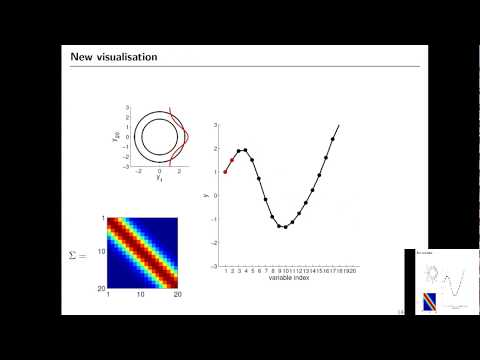

In [2]:
YouTubeVideo("92-98SYOdlY", width = 600, height=500)

# Motivation (problem statement)

One problem that can be solved with Gaussian Processes is the problem of linear regression with nonlinear basis functions. 
So... Looking at the figure below, given the red points we can create a Gaussian Process to predict the values might come from 
the function given by the darker blue curve,and we can give a measure of uncertainty in our
predictions shown by the light blue region.

(note that the curves only appear non-smooth because I have sampled from a small number of points, 
 part of being a 'reasonable' function is that it will be infinitely differentiable, i.e. smooooth )

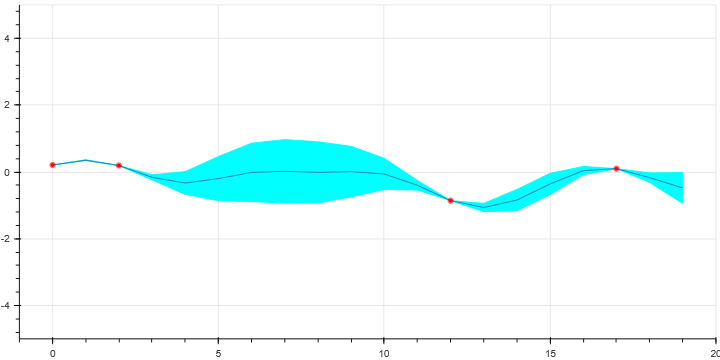

In [3]:
Image("plot1.jpeg")

# Definitions

The definition of a [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) is that it is a collection of [random variables](https://en.wikipedia.org/wiki/Random_variable) with the property that any finite subset of them will have a [multivariate normal distribution (MVN)](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). In our regression problem the random variables of the Gaussian Process will be the predicted and given function responces, y = f(x). They will be related to each other through the MVN distribution and sampling that distribution returns a regression function. Because we normally have no apriori knowledge of the function we are trying to predict, we normally assume a zero mean, and so only the covariance matrix of the MVN needs to be determined. As we shall see, we normally determine the covariance matrix by a function which we call the kernel. We will sovle the linear regression problem using basically only the MVN, so lets make sure we are familiar with it as we build our way up to creating a Gaussian Process. 

We start with the smallest number of dimensions, two. In two dimensions the [pdf](https://en.wikipedia.org/wiki/Probability_density_function) for the MVN takes the form: 

$$p(\textbf{y}) = \mathcal{N}(\textbf{y}\mid \mu, \Sigma) = \frac{1}{2\pi}{\mid\Sigma\mid}^{-\frac{1}{2}} e^{(\textbf{y} - \mu)^T\Sigma^{-1}(\textbf{y} - \mu)} $$
where 
$$\textbf{y} = \left[ {\begin{array}{c} y_1 \\ y_2 \end{array}}\right], \mu = \left[ {\begin{array}{c} \mu_1 \\ \mu_2 \end{array}}\right],
\Sigma = \left[ {\begin{array}{cc} 
\sigma_{11} & \sigma_{12} \\
\sigma_{21} & \sigma_{22}
\end{array}} \right]$$

$$ 
\sigma_{11} \text{ is the variance of } y_1, \\
\sigma_{22}  \text{ is the variance of } y_2, \\
\text{ and } \sigma_{12}=\sigma_{21} \text{ is the covariance between } y_1 \text{ and } y_2$$
As I said we normally assume the mean is zero 
$$  \mu = \left[ {\begin{array}{c} 0 \\ 0 \end{array}}\right]$$
so we end up with 
$$p(\textbf{y}) = \mathcal{N}(\textbf{y}\mid \textbf{0}, \Sigma) = \frac{1}{2\pi}{\mid\Sigma\mid}^{-\frac{1}{2}} e^{\textbf{y}^T\Sigma^{-1}\textbf{y}} $$

# Plot 1

The plot below shows a couple contour lines and a number of samples from the two-dimensional MVN with zero mean. Each of the variables have a [variance](https://en.wikipedia.org/wiki/Variance) of 1, and you can change the number of samples and [covariance](https://en.wikipedia.org/wiki/Covariance) between the two variables. Notice that when the covariance is near 0, the variable values tend to be unrelated and spread evenly in a circle around the orgin. When the covariance is near 1, the variable values tend to be near each other and the points concentrate along the diagonal, y1=y2.

In [3]:
if runlocal:
    func= show
    arg = GP1
else:
    func = HTML
    arg = iframe1
func(arg)

One key property of the MVN distribution is that if you are given values for a subset of the random variables, the remaining random variables will still have a Gaussian distribution. 
So they will still have a MVN distribution unless only one variable remains, then it will have a [Univariate Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution). That is if condition the MVN distribution on some of the variables, the [conditional distribution](https://en.wikipedia.org/wiki/Conditional_probability_distribution) will still be MVN.

# Derivation of Conditional Distribution

We can compute the analytic form of the conditional distribution as follows (feel free to skip to the text right above the next plot if you want to avoid following some computations):
First we permute our variables so that all the given (conditioning) variables come after the undetermined variables, when we do this we also need to permute the mean vector and the [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix).

Given our vector of random variables y, some of which have given values and some of which do not, we determine the needed [permution matrix](https://en.wikipedia.org/wiki/Permutation_matrix) P such that,
$$
P\textbf{y} = \left[ {\begin{array}{c} \textbf{y}_a \\ \textbf{y}_b \end{array}}\right],\\
\textbf{y}_b \text{ is the vector of given variables, and } \\ 
\textbf{y}_a \text{ is the vector of unknown variables.} 
$$
We then use properties of permutation matrices, determinants and inverses to get the following and permute our whole MVN;
$$ \textbf{y}^T\Sigma^{-1}\textbf{y} = 
\textbf{y}^TP^TP\Sigma^{-1}P^TP\textbf{y} = 
(P\textbf{y})^T(P\Sigma^{-1}P^T)(P\textbf{y}) = 
(P\textbf{y})^T(P\Sigma P^T)^{-1}(P\textbf{y})$$
and 
$${\mid\Sigma\mid}^{-\frac{1}{2}} =
(\mid P\mid \mid P^T \mid \mid \Sigma \mid)^{-\frac{1}{2}} = 
(\mid P \mid  \mid \Sigma \mid \mid P^T \mid)^{-\frac{1}{2}} = 
(\mid P \Sigma  P^T \mid)^{-\frac{1}{2}} 
$$
This then allows us, by insertion of the identy matrix, to [partition](https://en.wikipedia.org/wiki/Block_matrix) our (joint) MVN in the form,
$$ \mathcal{N}(\textbf{y'}\mid \mu', \Sigma') = \mathcal{N}(P\textbf{y}\mid P\mu, P\Sigma P^T) $$where 
$$\textbf{y'} = \left[ {\begin{array}{c} \textbf{y}_a \\ \textbf{y}_b \end{array}}\right], \mu' = \left[ {\begin{array}{c} \mathbf{\mu_a} \\ \mathbf{\mu_b} \end{array}}\right],
\Sigma' = \left[ {\begin{array}{cc} 
\Sigma_{aa} & \Sigma_{ab} \\
\Sigma_{ba} & \Sigma_{bb}
\end{array}} \right]$$
We henceforth assume our original MVN was partitioned this way and dont write any ' or P matrices.
The inverse of the covariance matrix is called the precision matrix. Here we find it useful to work with the partioned form of the precision matrix,
$$
\Sigma^{-1} = \Lambda =  \left[ {\begin{array}{cc} 
\Lambda_{aa} & \Lambda_{ab} \\
\Lambda_{ba} & \Lambda_{bb}
\end{array}} \right]$$
There is a useful [formula](http://en.wikipedia.org/wiki/Matrix_inverse#Blockwise_inversion) for the relation between the partioned covariance matrix and the partioned precision matrix which we will need later. We want to determine the pdf of the conditional distribution 
$$p(\textbf{y}_a \mid \textbf{y}_b).$$
The product rule of probability tells us, $$ p(\textbf{y}_a \mid \textbf{y}_b) = \frac{p(\textbf{y}_a, \textbf{y}_b)}{ p(\textbf{y}_b)} $$
This means that the conditional distribution as a function of y_a is proportional to the joint distribution, so to determine the desired conditional pdf we only need to take our original joint pdf, fix the given values, and normalize the result. Actually, as we will see, we can use this fact to observe the form of the distribution after fixing the given values, see the the form is that of a gaussian distribution and just determine the parameters (mean, and variance) of that distribution. Using the partioning we have formed we focus on the variable parts of the joint pdf
$$ -\frac{1}{2}(\textbf{y} - \mathbf{\mu})^T\Sigma^{-1}(\textbf{y} - \mathbf{\mu}) = \\
-\frac{1}{2}(\textbf{y}_a -\mathbf{\mu_a})^T\Lambda_{aa} (\textbf{y}_a - \mathbf{\mu_a})
-\frac{1}{2}(\textbf{y}_a -\mathbf{\mu_a})^T\Lambda_{ab} (\textbf{y}_b - \mathbf{\mu_b})
-\frac{1}{2}(\textbf{y}_b -\mathbf{\mu_b})^T\Lambda_{ba} (\textbf{y}_a - \mathbf{\mu_a})
-\frac{1}{2}(\textbf{y}_b -\mathbf{\mu_b})^T\Lambda_{bb} (\textbf{y}_b - \mathbf{\mu_b})\\ = 
Q(\textbf{y}_a,\textbf{y}_a)
$$ 
When y_b is given we are only interested in how this is a function of y_a, any part not involving y_a is constant and will be taken care of when we normalize the distribution. As a funtion of y_a this is a quadratic form and therefore our conditional distribution will be of the form:
$$ p(\textbf{y}_a \mid \textbf{y}_b) = C e^{Q(\textbf{y}_a,\textbf{y}_a)}
$$
Any distribution of this form is a guassian. We can see that by multiplying out the exponent of the MVN.
$$ -\frac{1}{2}(\textbf{y} - \mathbf{\mu})^T\Sigma^{-1}(\textbf{y} - \mathbf{\mu}) = \\
-\frac{1}{2}\textbf{y}^T\Sigma^{-1}\textbf{y} + \textbf{y}^T\Sigma^{-1}\mathbf{\mu} + C 
$$
Because we see our conditional distribution is gaussian, and we know that any gaussian distribution is completely specified by its mean and covariance, we can ignore the problem of normalizing and just determine the mean and covariance matrix. We see that the squared terms of the quadratic form will determine the inverse covariance matrix and the linear terms will be determine the product of the inverse covariance times the mean. So by equating parts we conclude
$$ \Sigma_{a \mid b} = \Lambda_{aa}^{-1}\\
\text{ and } \\
\mu_{a \mid b} = \Sigma_{a \mid b}(\Lambda_{aa}\mu_{a} - \Lambda_{ab}(\textbf{y}_b - \mathbf{\mu}_b)) = 
\mu_{a} - \Lambda_{aa}^{-1}\Lambda_{ab}(y_b - \mu_b)
$$
using the formula to relate the inverse of the partitioned covariance matrix to the partitioned precision matrix, we get the important formulas:
$$ 
\mu_{a \mid b} = \mu_{a} + \Sigma_{ab}\Sigma_{bb}^{-1}(y_b - \mu_b)   \\
\Sigma_{a \mid b} = \Sigma_{aa} - \Sigma_{ab} \Sigma_{bb}^{-1}\Sigma_{ba}
$$
These completely determine our conditional distribution and are the heart of Gaussian Processes for nonlinear regression.

Ok, lets return from our mathematical digression where we have seen how to get the conditional gaussian distribution from a joint gaussian distribution. Let's now use these results to explore the behavior of conditional distribution with more plots.

# Plot 2

In the plot below we fix y1 as given and then sample y2. The distribution of y2 given y1 will be a univariate normal, and the pdf is shown in the red curve. From what we have derived above and using 0 mean and var(y_1) = var(y_2) = 1, the distribution of y2 will be normally distributed with 
$$
\mu = \mu_{a \mid b} =  \sigma_{ab} y_1 \\
\sigma = \sigma_{a \mid b} = 1 -  \sigma_{ab} ^2
$$
Imagine the red curve is coming out of the screen, this is a slice of the two dimentional gaussian along the vertical axis. You can see the effect of the pdf and samples as the covariance and given value of y1 change. Also notice how the uncertainty as messured by the conditional standard deviation (width of the conditional pdf) changes as the covariance changes.

In [4]:
if runlocal:
    func= show
    arg = GP2
else:
    func = HTML
    arg = iframe2
func(arg)

# Plot 3

To increase the dimension and step towards our regression function we introduce a new way to visualize the samples from a two-dimensional gaussian.
In the figure below on the left we have our normal 2-d gaussian, a few contour lines and a single sample point. In the figure on the right we plot that single point in a different way.
We take that single sample and plot the variable value vs the variable index. If our two dimensional sample is [y1, y2] we plot the points
(1,y1) and (2,y2), i.g. [.8, 1.2] gets plotted as (1,.8) and (2,1.2). Now we can see that as the variables are more correlated their heights will be closer together and the the less correlated they are the more the heights tend to be different.

In [6]:
if runlocal:
    func= show
    arg = GP3
else:
    func = HTML
    arg = iframe3
func(arg)

# Plot 4

We can similarly fix one of the variables to a given value and sample the other. Note how a high covariance pins the sampled height close to the given value while a low covariance allows the adjacent point to be far from the given point. 

In [7]:
if runlocal:
    func= show
    arg = GP4
else:
    func = HTML
    arg = iframe4
func(arg)

# Plot 5

Now lets increase the number of dimensions. In the plot below we sample from a 3 to 20 dimensional gaussian. We can change the number of given points and change the covariance between the points with the theta_1 slider.
A small theta_1 is high covariance, notice how a high covariance will produce little variability in the sampled curves, while a low covariance will produce samples that squirm all over the place.

The covariance matrix for this plot is formed by using the following function to compute its entries:
$$
 kernel(x1,x2) = e^{-\frac{\theta_1}{2}(x1-x2)^2}
$$
where x1, x2 take on the values 1,2,..., num_points. Note increasing theta_1 will reduce the covariance between all unequal inputs

In [8]:
if runlocal:
    func= show
    arg = GP5
else:
    func = HTML
    arg = iframe5
func(arg)

# Review/Overview/Summary

Now this is starting to look like nonlinear regression... But it might seem artificial, perhaps your wondering about our restriction of x to take integer values.
Lets review what we have learned to do. We can take a set values we want to evaluate our function at,
$$
\mathcal{C} = \{ x_{1}, \cdots , x_{M} \} = \{ \mathbf{x}_a \}
$$
and a setof given data,
$$ 
\mathcal{D} = \{ (x_{M+1}, y_{M+1}), (x_{M+2}, y_{M+2}), \cdots , (x_{M+N}, y_{M+N}) \} = \{ (\mathbf{x}_b, \mathbf{y}_b) \}
$$
If we form a joint distribution over the whole set of values,
$$ \mathbf{y} = [ y_1, y_2, \cdots , y_M, y_{M+1}, \cdots ,y_{M+N} ]^T \\
p(\mathbf{y}) = \mathcal{N}(\mathbf{y} \mid \mathbf{0}, \Sigma),
$$ 
with
$$
\Sigma = \left[ {\begin{array}{cc} 
\Sigma_{aa} & \Sigma_{ab} \\
\Sigma_{ba} & \Sigma_{bb}
\end{array}} \right]
$$
then we can create a conditional distribution over the unknown y's given the known y's by using the formule we have derived.
$$ 
p(\mathbf{y}_a \mid \mathbf{y}_b) = \mathcal{N}(\mathbf{y}_a \mid \mu_{a \mid b}, \Sigma_{a \mid b})\\
\mu_{a \mid b} = \Sigma_{ab}\Sigma_{bb}^{-1}y_b  \\
\Sigma_{a \mid b} = \Sigma_{aa} - \Sigma_{ab} \Sigma_{bb}^{-1}
$$
All that we haven't shown how to do is form the covariance matrix.

There are many ways we can create the covariance matrix, we saw one in plot 5. It turns out that the elements of the covariance matrix can be formed by any positive definite function of the form:
$$
k(x_m, x_n): \mathcal{R}^D \times \mathcal{R}^D \rightarrow \mathcal{R}
$$
We call such a function a kernel.
Note that the x vectors are allowed to be arbitrary D dimensional vectors. There has been no explicit use of the x values in our Guassian Process formulation, so we can easily permit its use in D-dimensional linear regression.
    

# Gaussian Process from basis function regression

Let's see how we can determine the kernel used in the tradition linear regression with basis functions. Recall that the linear regression model with a set of basis functions takes the form.
$$
y(\mathbf{x}, \mathbf{w}) = \sum_{j=0}^{M-1} w_j\phi_j(\mathbf{x}) = \mathbf{w}^T\mathbf{\phi(x)}
$$
where
$$ \mathbf{w} = ( w_0, \cdots, w_{M-1})^T \\
\text{ and } \\
\mathbf{\phi} = ( \phi_0, \cdots, \phi_{M-1})^T \text{ with } \phi_0(\mathbf{x}) = 1 
$$
the basis funtions, phi_j, are normally prechoosen and we seek to determine the w_j.
If we are given some data relating x and y,
$$
\mathcal{D} = \{ (x_{1}, y_{1}), (x_{2}, y_{2}), \cdots , (x_{N}, y_{N}) \}
$$

we relate them through our regression model as
$$
\mathbf{y} = \Phi\mathbf{w} = 
\begin{bmatrix} 
\mathbf{\phi(x_1)}  \\
\vdots \\
\mathbf{\phi(x_N)}
\end{bmatrix} 
\begin{bmatrix} 
w_1 \\ \vdots \\ w_N 
\end{bmatrix} 
= \begin{bmatrix} 
\phi_1(x_1) \cdots \phi_M(x_1)  \\
\vdots \ddots \vdots\\
\phi_1(x_N) \cdots \phi_M(x_N)
\end{bmatrix} 
\begin{bmatrix} 
w_1 \\ \vdots \\ w_N 
\end{bmatrix} \\
\Phi \text{ is called the design matrix}
$$

Since the w_j are unknown variables, lets consider them as random variables.
Assume that they come from a gaussian distribution with mean 0.
$$
p(w) = \mathcal{N}(\mathbf{w} \mid \mathbf{0}, \alpha^{-1} \mathbf{I})
$$
Then since the y_j are a linear combination of the gaussian w_j, they will also have a gaussian distribution. We can determine their mean and covariance matrix as follows:
$$
\mathbf{E}(\mathbf{y}) = \Phi \mathbf{E}[\mathbf{w}] = \mathbf{0} \\
cov[\mathbf{y}] = \mathbf{E}[(\mathbf{y} - \mathbf{E}[\mathbf{y}])^T(\mathbf{y} - \mathbf{E}[\mathbf{y}])] = \mathbf{E}[\mathbf{y}^T\mathbf{y}] = \Phi \mathbf{E}[\mathbf{ww}^T] \Phi^T = \frac{1}{\alpha}\Phi \Phi^T = \mathbf{K}
$$
where K is called the Gram matrix and has elements,
$$
K_{nm} = k(x_n,x_m) = \frac{1}{\alpha}\mathbf{\phi}(\mathbf{x_n})^T\mathbf{\phi}(\mathbf{x_m})
$$
So once again we have a zero mean MVN distribution for the output values and we see how to form the covariance matrix.